### Reference

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from os import path
import matplotlib.pyplot as plt

### Data Manipulation

In [2]:
def dataManipulation(cid):
    filePath = r'./dataset/'+str(cid)+'.csv'
    if not path.exists(filePath): # 判断cid是否正确
        print('please input correct CID')
        return 
    df_test = pd.read_csv(filePath)
    #df_test.drop(columns=['CID','CATEGORY','MANUFACTURER_NAME','PRODUCT_NAME'],inplace=True)
    df_test.drop(columns=['CID','MANUFACTURER_NAME','PRODUCT_NAME'],inplace=True)
    df_test['Grand Total'] = df_test.mean(numeric_only=True, axis=1)
    df_test.ffill(inplace=True)
    nan_percent =100*(df_test.isnull().sum()/len(df_test))>0.4
    nan_value = nan_percent[nan_percent.values==True].index
    df_test.drop(columns= nan_value,inplace=True)
    df_test['COLLECTION_DATE'] = pd.to_datetime(df_test['COLLECTION_DATE']) # transform date into proper type
    return df_test
    # df_test.head()

In [3]:
ddd = dataManipulation(5280102)
ddd.head()

,COLLECTION_DATE,CATEGORY,Target,Walmart,Amazon,Grand Total
0,2021-01-01,Baby Nursing And Feeding,23.99,23.99,23.99,23.99
1,2021-01-02,Baby Nursing And Feeding,23.99,23.99,23.99,23.99
2,2021-01-03,Baby Nursing And Feeding,23.99,23.99,23.99,23.99
3,2021-01-04,Baby Nursing And Feeding,23.99,23.99,23.99,23.99
4,2021-01-05,Baby Nursing And Feeding,23.99,23.99,23.99,23.99


#### category_index

In [4]:
# dfcate = pd.read_csv(r'./dataset/CATEGORY CHANGE.csv')
# print(dfcate.head())
# dfCategory = pd.merge(ddd,dfcate,how='left',left_on=['COLLECTION_DATE','CATEGORY'],right_on=['COLLECTION_DATE','CATEGORY'])
# print(dfCategory.head())

### Functions

In [5]:
# get platform name, return excepted price strategy each day from Grand Total
def strategy_one(df,colName):
    dataFrame =df.copy(deep=True) # get a copy of origin dataframe, so the following editting won't change origin
    newColName = 'strategy1'+colName #define: column name = strategy+platform 
    dataFrame[newColName] = dataFrame['Grand Total']
    return dataFrame,newColName


In [6]:
# get platform name,dataframe, return excepted price strategy each day from rolling five days
def strategy_two(df,colName):
    dataFrame =df.copy(deep=True)
    newColName = 'strategy2'+colName
    dataFrame[newColName] = dataFrame['Grand Total'].rolling(5,min_periods=1).mean()
    return dataFrame,newColName


In [7]:
# get platform name,dataframe,
# each day extreme price difference
# return expected dataframe, new column name
def strategy_three(df,colName):
    dataFrame =df.copy(deep=True)
    newColName = 'strategy3'+colName
    dataFrame[newColName] = dataFrame[colName]+dataFrame['Amazon']-dataFrame['Target']
    return dataFrame,newColName

In [8]:
def strategy_threepointfive(df,colName):
    dataFrame =df.copy(deep=True)
    newColName = 'strategy3.5'+colName
    # 按目标平台价格变动百分比，变动
    dataFrame[newColName] = dataFrame[colName]*(1+((dataFrame['Amazon']-dataFrame['Amazon'].shift(1))/dataFrame['Amazon'].shift(1)))
    return dataFrame,newColName

In [9]:
# get platform name,dataframe,cost percentage in total price
# current avg product price *0.8 = cost, using cost as model baseline  
# return expected dataframe, new column name
def strategy_four(df,colName,costPercentage =0.8):
    dataFrame =df.copy(deep=True)
    newColName = 'strategy4'+colName
    
    def baseToMean(curPrice, Grand):
        if curPrice*costPercentage >Grand:
            return curPrice*costPercentage
        else:
            return Grand
    dataFrame[newColName] = dataFrame[[colName,'Grand Total']].apply(lambda x:baseToMean(x[colName],x['Grand Total']),axis =1)

    return dataFrame,newColName

In [10]:
# input: pDf:product dataframe must include category Rate
#        
# output:
#        new product price vary with category index


def strategy_five(pDf,colName):
    productDf = pDf.copy(deep=True)
    productDf['RATE'] = productDf['RATE'].str.rstrip('%').astype('float') / 100.0
    productDf['RATE'].fillna(0.0,inplace =True)
    #dfCategory = pd.merge(productDf,cateDf,how='left',left_on=['COLLECTION_DATE','CATEGORY'],right_on=['COLLECTION_DATE','CATEGORY'])
    newColName = 'strategy5'+colName
    productDf[newColName] = productDf[colName]*(1+productDf['RATE'])
    return productDf,newColName

In [11]:
def demandRevenue(dataframe, colName):
    df =  dataframe.copy(deep=True)
    df['Demand'+colName]=100-0.7*df[colName]+0.5*(df["Grand Total"]-df[colName])
    df['Revenue'+colName]=df['Demand'+colName]*df[colName]
    return df

### WorkFlow
- require for platform name
- calculate the origin demands and revenue
- calcualte three strategies' demands and revenue
- visualize the outcome

In [32]:
def workflow():
    #PlatName = input('plz input platform name')
    PlatName = 'Amazon'
    df_test = dataManipulation('5237383')
    df1 = df_test.copy(deep=True)
    if PlatName not in df1.columns:
        print('please input the existed platform')
        return 0
    df2=demandRevenue(df1,PlatName)
    df2, c3name= strategy_three(df2,PlatName)
    df3= demandRevenue(df2,c3name)
    df3, c2name= strategy_two(df3,PlatName)
    df4 =demandRevenue(df3,c2name)
    df4, c1name= strategy_one(df4,PlatName)
    df5 =demandRevenue(df4,c1name)
    df5, c4name= strategy_four(df5,PlatName)
    df6 =demandRevenue(df5,c4name)

    #data prepare for strategy five
    dfcate = pd.read_csv(r'./dataset/CATEGORY CHANGE.csv')
    dfcate['COLLECTION_DATE']=pd.to_datetime(dfcate['COLLECTION_DATE'])
    dfCategory = pd.merge(df6,dfcate,how='left',left_on=['COLLECTION_DATE','CATEGORY'],right_on=['COLLECTION_DATE','CATEGORY'])
   
    df6, c5name= strategy_five(dfCategory,PlatName)
    df7 =demandRevenue(df6,c5name)
    #df5.head()

    ori_revenue = df7['Revenue'+PlatName].sum()
    revenue1=(df7['Revenue'+c1name]).sum()-ori_revenue
    revenue2=(df7['Revenue'+c2name]).sum()-ori_revenue
    revenue3=(df7['Revenue'+c3name]).sum()-ori_revenue
    revenue4=(df7['Revenue'+c4name]).sum()-ori_revenue
    revenue5=(df7['Revenue'+c5name]).sum()-ori_revenue
    revenueCompare = {'strategy1':round(revenue1,2),
                        'strategy2':round(revenue2,2),
                        'strategy3':round(revenue3,2),
                        'strategy4':round(revenue4,2),
                        'strategy5':round(revenue5,2)}
    max_key = str(max(revenueCompare,key=revenueCompare.get))
    max_value = str(max(revenueCompare.values()))
    max_strategy =max_key+': '+max_value
    
    print(revenueCompare)
    print(max_strategy)
    print(Visualization(pd.to_datetime(df7['COLLECTION_DATE']),df7['Revenue'+ max_key+PlatName]-df7['Revenue'+PlatName],df7[max_key+PlatName]))
    #print(visualizeRevenue(df7['Revenue'+PlatName],df7['Revenuestrategy1'+PlatName],df7['Revenuestrategy2'+PlatName],df7['Revenuestrategy3'+PlatName]))
    return df7


In [33]:
'''Input:
        CID
        Demand_index
        Platform
        Strategy'''

result = workflow()

{'strategy1': -376699.29, 'strategy2': -374862.79, 'strategy3': 177788.8, 'strategy4': -146777.3, 'strategy5': -151.58}
strategy3: 177788.8


KeyError: 'Revenuestrategy3Amazon'

### Visualization

In [18]:
# x：日期 datatype: datetime
# y1：不同策略revenue差值 series
# y2: 该策略的价格 series
# 最佳策略的strategy price 以及 culminative revenue
def Visualization(x ,y1,y2):   
    # df2 = result
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax1 = fig.add_subplot(111)
    ax1.fill_between(x, np.cumsum(y1), color="skyblue", alpha=0.2, label="Cumulative Difference")
    ax1.plot(x, np.cumsum(y1), color="Slateblue", alpha=0.6)
    ax1.legend(loc="upper left")
    ax1.set_ylabel('Revenue Contribution')
    ax1.set_xlabel('Date')
    ax2 = ax1.twinx()  # this is the important function
    ax2.plot(x, y2, color='darkorange',alpha=0.7, label="Price")
    ax2.legend(loc="upper center")
    ax2.set_ylabel('Price')
    plt.xticks(pd.date_range('2020-06','2022-12',freq='4m'))
    plt.show()



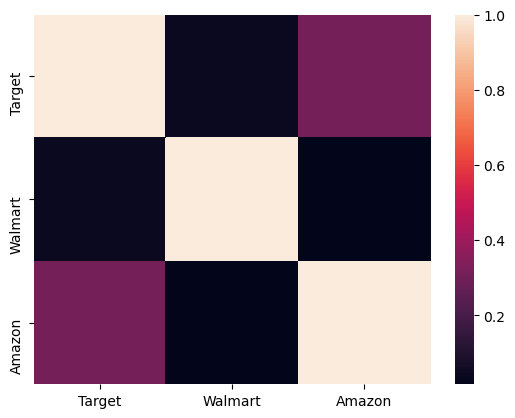

In [27]:
df3=result.iloc[:,2:5]
df4=result.iloc[:,2:5]

for i in range(1,df4.shape[0]):
  df4.iloc[i,:]=(100*(df3.iloc[(i),:]-df3.iloc[i-1,:])/df3.iloc[i,:])
  i=i+1

df_correlation=df4.corr()
ax = sns.heatmap(df_correlation)

In [23]:
# origin: origin revenue 
# revenueS1..3 : Total revenue for strategy 1 to 3
#                datatype: Dataframe
def visualizeRevenue(origin,revenueS1,revenueS2,revenueS3):
    label=['original', 'strategy1','strategy2','strategy3']
    revenue_value=[origin.sum(),revenueS1.sum(),revenueS2.sum(),revenueS3.sum()]
    fig = plt.figure(figsize=(6, 4), dpi=100)
    plt.bar(label,revenue_value, color='skyblue')
    plt.axhline(origin.sum(),color='black',alpha=0.7,linestyle='--')
    plt.title("Total revenue of different strategies")
